#Importing the dataset


In [ ]:
#Install kaggle
!pip install -q kaggle


In [ ]:

from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"gayanthikashankar","key":"5b9c41bbeec3ed9536d9e2eb3ff1e91e"}'}

In [ ]:
#Create a kaggle folder
! mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
#Copy the kaggle.json to created folder
! cp kaggle.json ~/.kaggle/

In [ ]:
#Permission for the json to act
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Download Audio MNIST dataset
!kaggle datasets download sripaadsrinivasan/audio-mnist

Dataset URL: https://www.kaggle.com/datasets/sripaadsrinivasan/audio-mnist
License(s): CC0-1.0
audio-mnist.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#Unzip to access audio files
!unzip audio-mnist.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/51/0_51_1.wav      
  inflating: data/51/0_51_10.wav     
  inflating: data/51/0_51_11.wav     
  inflating: data/51/0_51_12.wav     
  inflating: data/51/0_51_13.wav     
  inflating: data/51/0_51_14.wav     
  inflating: data/51/0_51_15.wav     
  inflating: data/51/0_51_16.wav     
  inflating: data/51/0_51_17.wav     
  inflating: data/51/0_51_18.wav     
  inflating: data/51/0_51_19.wav     
  inflating: data/51/0_51_2.wav      
  inflating: data/51/0_51_20.wav     
  inflating: data/51/0_51_21.wav     
  inflating: data/51/0_51_22.wav     
  inflating: data/51/0_51_23.wav     
  inflating: data/51/0_51_24.wav     
  inflating: data/51/0_51_25.wav     
  inflating: data/51/0_51_26.wav     
  inflating: data/51/0_51_27.wav     
  inflating: data/51/0_51_28.wav     
  inflating: data/51/0_51_29.wav     
  inflating: data/51/0_51_3.wav      
  inflating: data/51/0_51_30.wav     
  inflating: data/51/0_51_31.wav     

#Play and visualize the chosen audio file

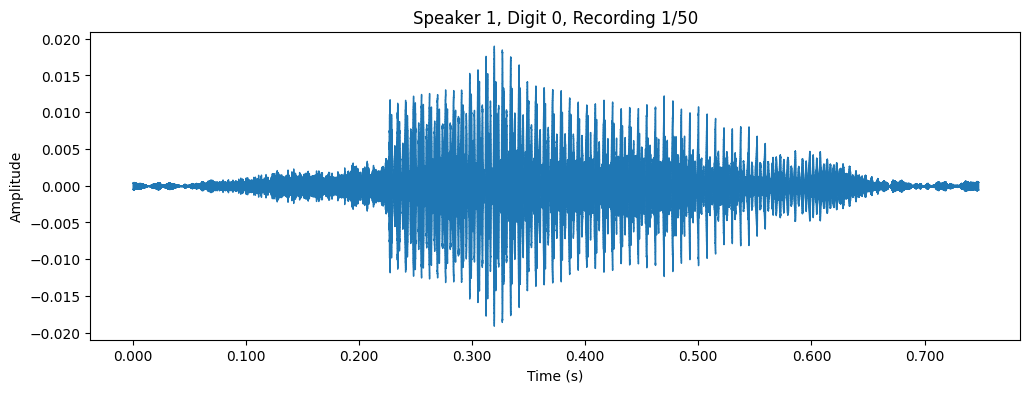

In [ ]:
import numpy as np
import librosa
import librosa.display as dsp
import matplotlib.pyplot as plt
from IPython.display import Audio, display, clear_output
import os
import ipywidgets as widgets

class SequentialAudioPlayer:
    def __init__(self, base_path="data"):
        #Initialize player with file paths and UI controls
        self.base_path = base_path
        self.current_speaker = None
        self.current_digit = 0
        #Define navigation order for recordings
        self.recording_order = ['0','1','10','11','12','13','14','15','16','17','18','19','2',
                              '20','21','22','23','24','25','26','27','28','29','3','30','31',
                              '32','33','34','35','36','37','38','39','4','40','41','42','43',
                              '44','45','46','47','48','49','5','6','7','8','9']
        self.current_index = 0
        self.total_recordings = 50  #Recordings per speaker

        #Initialize UI input widgets and controls
        self.speaker_input = widgets.IntText(
            value = 1,
            description = 'Speaker:',
            min = 1,
            max = 60
        )

        self.digit_input = widgets.IntText(
            value = 0,
            description = 'Digit:',
            min = 0,
            max = 9
        )

        self.play_button = widgets.Button(description="Play")
        self.next_button = widgets.Button(description="Next")
        self.prev_button = widgets.Button(description="Previous")
        self.jump_input = widgets.IntText(
            value = 1,
            description = 'Jump to:',
            min = 1,
            max = 500
        )
        self.jump_button = widgets.Button(description = "Jump")

        #Labels to track position and the current file
        self.position_label = widgets.Label()
        self.filename_label = widgets.Label()

        #Connect button click handlers
        self.play_button.on_click(self.play_current)
        self.next_button.on_click(self.next_audio)
        self.prev_button.on_click(self.prev_audio)
        self.speaker_input.observe(self.speaker_changed, names = 'value')
        self.digit_input.observe(self.digit_changed, names = 'value')
        self.jump_button.on_click(self.jump_to_recording)

        #Building the player
        self.controls = widgets.VBox([
            widgets.HBox([
                self.speaker_input,
                self.digit_input,
                self.prev_button,
                self.play_button,
                self.next_button
            ]),
            widgets.HBox([
                self.jump_input,
                self.jump_button
            ]),
            self.position_label,
            self.filename_label
        ])

    def get_current_recording_number(self):
        #Convert position to recording number (1-500)
        return self.current_digit * 50 + self.current_index + 1

    def get_file_path(self):
        #File path from current position
        speaker = self.current_speaker
        digit = self.current_digit
        index = self.recording_order[self.current_index]
        speaker_str = f"0{speaker}" if speaker < 10 else str(speaker)
        filename = f"{digit}_{speaker_str}_{index}.wav"
        return os.path.join(self.base_path, speaker_str, filename), filename

    def update_labels(self):
        #Current position label
        file_path, filename = self.get_file_path()
        current_recording = self.get_current_recording_number()
        self.position_label.value = f"Recording {current_recording}/500"
        self.filename_label.value = f"Current file: {filename}"

    def speaker_changed(self, change):
        #Reset position when speaker changes
        self.current_speaker = change.new
        self.current_digit = self.digit_input.value
        self.current_index = 0
        self.update_labels()
        self.display_current()

    def digit_changed(self, change):
        #Reset position when digit changes
        self.current_digit = change.new
        self.current_index = 0
        self.update_labels()
        self.display_current()

    def jump_to_recording(self, b=None):
        #Navigate to chosen recording number
        target = self.jump_input.value
        if 1 <= target <= 500:
            self.current_digit = (target - 1) // 50
            self.current_index = (target - 1) % 50
            self.digit_input.value = self.current_digit
            self.update_labels()
            self.display_current()

    def play_current(self, b=None):
        #Play current audio file
        file_path, _ = self.get_file_path()
        if os.path.exists(file_path):
            data, sr = librosa.load(file_path)
            display(Audio(data=data, rate=sr, autoplay=True))

    def next_audio(self, b=None):
        #Next recording
        self.current_index += 1
        if self.current_index >= 50:
            self.current_index = 0
            self.current_digit += 1
            if self.current_digit > 9:
                self.current_digit = 0
                new_speaker = self.current_speaker + 1
                if new_speaker <= 60:
                    self.speaker_input.value = new_speaker
        self.digit_input.value = self.current_digit
        self.update_labels()
        self.display_current()

    def prev_audio(self, b=None):
        #Previous recording
        self.current_index -= 1
        if self.current_index < 0:
            self.current_index = 49
            self.current_digit -= 1
            if self.current_digit < 0:
                self.current_digit = 9
                new_speaker = self.current_speaker - 1
                if new_speaker >= 1:
                    self.speaker_input.value = new_speaker
        self.digit_input.value = self.current_digit
        self.update_labels()
        self.display_current()

    def display_current(self):
        #Visualize audio
        clear_output(wait=True)
        display(self.controls)

        file_path, _ = self.get_file_path()
        if os.path.exists(file_path):
            data, sr = librosa.load(file_path)
            plt.figure(figsize=(12, 4))
            dsp.waveshow(data, sr=sr)
            plt.title(f"Speaker {self.current_speaker}, Digit {self.current_digit}, Recording {self.current_index + 1}/50")
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")
            plt.show()
        else:
            print(f"File not found: {file_path}")

def create_player():
    #Display interface
    player = SequentialAudioPlayer()
    player.current_speaker = player.speaker_input.value
    player.display_current()
    return player

if __name__ == "__main__":
    player = create_player()

#Extracting MFCC Coefficients from the audio files

<Figure size 640x480 with 0 Axes>

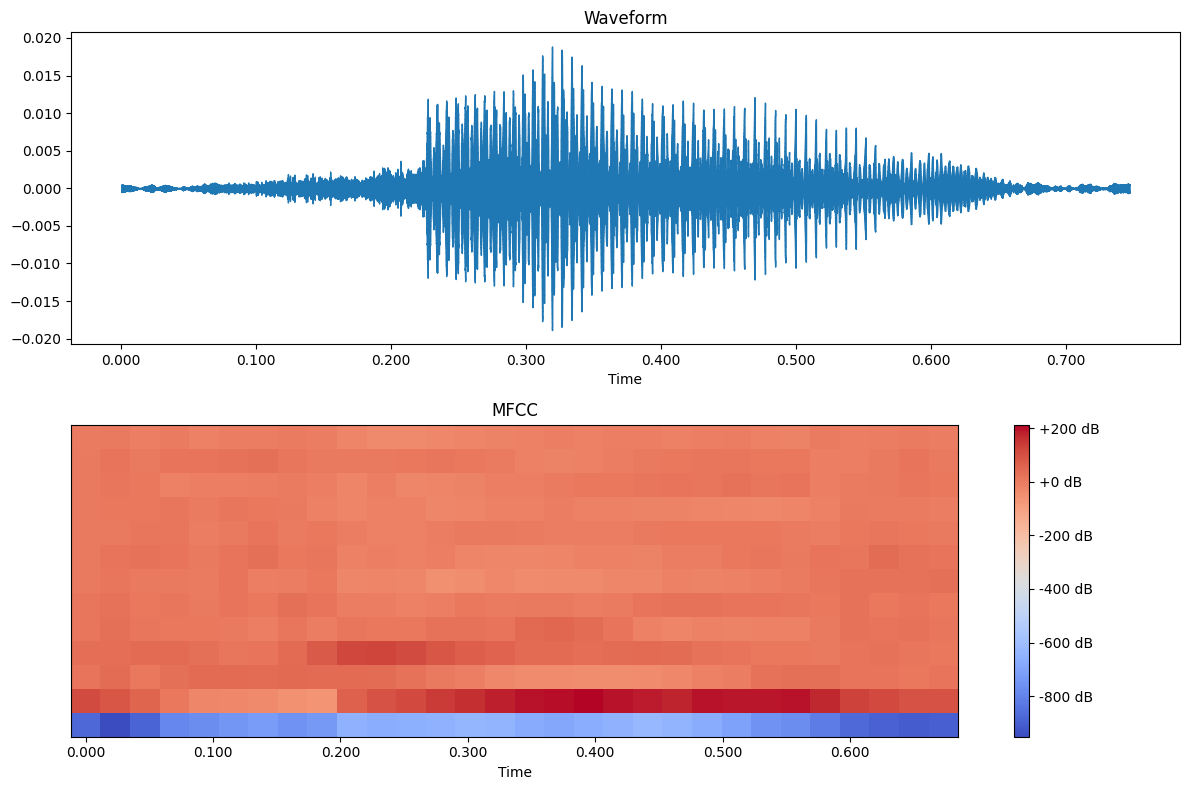

In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import IPython.display as ipd

def extract_mfcc(audio_path, sample_rate=16000, window_length=0.03, hop_length=0.025, n_mfcc=13):
    #Extract MFCC features from audio file
    try:
        audio, sr = librosa.load(audio_path, sr=sample_rate)
        #Calculate FFT parameters
        n_fft = int(window_length * sample_rate)
        hop_length_samples = int(hop_length * sample_rate)

        #Compute MFCC features
        mfcc = librosa.feature.mfcc(
            y = audio,
            sr = sample_rate,
            n_mfcc = n_mfcc,
            n_fft = n_fft,
            hop_length = hop_length_samples
        )
        return mfcc.T
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None

def visualize_mfcc(audio_path, sample_rate=16000):
    #Visualize audio and extracted MFCC Features
    plt.clf()

    #Load and process audio
    audio, sr = librosa.load(audio_path, sr=sample_rate)
    mfcc = extract_mfcc(audio_path, sample_rate)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    #Plot waveform and MFCC
    librosa.display.waveshow(y=audio, sr=sr, ax=ax1)
    ax1.set_title('Waveform')
    img = librosa.display.specshow(mfcc.T, x_axis='time', ax=ax2)
    fig.colorbar(img, ax=ax2, format='%+2.0f dB')
    ax2.set_title('MFCC')

    plt.tight_layout()
    plt.show()
    return ipd.Audio(audio, rate=sr)

#Test visualization on sample file
sample_file = "data/01/0_01_0.wav"
visualize_mfcc(sample_file)

#Prepare the dataset

In [ ]:
#Import required libraries
import numpy as np
import librosa
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def process_file(args):
    #Pad/truncate MFCC features to fixed length
    file_path, speaker = args
    mfcc = extract_mfcc(file_path)
    if mfcc is not None:
        #Standardize MFCC length to 40 frames (explained why in report)
        if mfcc.shape[0] < 40:
            pad_width = ((0, 40 - mfcc.shape[0]), (0, 0))
            mfcc = np.pad(mfcc, pad_width, mode='constant')
        else:
            mfcc = mfcc[:40, :]
        return mfcc, speaker - 1
    return None

def prepare_dataset(base_path="data", test_size=0.2, verbose=True):
    if verbose:
        print("Preparing dataset...")

    #Collect all audio files
    file_list = []
    for speaker in range(1, 61):
        speaker_dir = f"{base_path}/{'0' + str(speaker) if speaker < 10 else str(speaker)}"
        if not os.path.exists(speaker_dir):
            continue
        for file in os.listdir(speaker_dir):
            if file.endswith('.wav'):
                file_list.append((os.path.join(speaker_dir, file), speaker))

    #Extract features
    features = []
    labels = []
    with ThreadPoolExecutor(max_workers=8) as executor:
        results = list(tqdm(executor.map(process_file, file_list),
                          total=len(file_list),
                          desc="Processing audio files"))

    #Collect successful results
    for result in results:
        if result is not None:
            features.append(result[0])
            labels.append(result[1])

    #Convert to numpy arrays and split dataset
    X = np.array(features)
    y = np.array(labels)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    #Normalize features
    for i in range(X_train.shape[2]):
        mean = X_train[:, :, i].mean()
        std = X_train[:, :, i].std()
        X_train[:, :, i] = (X_train[:, :, i] - mean) / std
        X_test[:, :, i] = (X_test[:, :, i] - mean) / std

    if verbose:
        print("\nDataset Info:")
        print(f"Total samples: {len(features)}")
        print(f"Training samples: {len(X_train)}")
        print(f"Test samples: {len(X_test)}")
        print(f"Feature dimensions: {X_train.shape}")
        print(f"Number of speakers: {len(np.unique(y_train))}")
        print(f"Files processed: {len(results)}")

    return X_train, X_test, y_train, y_test

class SpeakerDataset(Dataset):
    #PyTorch dataset for speaker recognition
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

#Create and load datasets
if __name__ == "__main__":
    X_train, X_test, y_train, y_test = prepare_dataset()
    train_dataset = SpeakerDataset(X_train, y_train)
    test_dataset = SpeakerDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Preparing dataset...


Processing audio files: 100%|██████████| 30000/30000 [03:53<00:00, 128.52it/s]



Dataset Info:
Total samples: 30000
Training samples: 24000
Test samples: 6000
Feature dimensions: (24000, 40, 13)
Number of speakers: 60
Files processed: 30000


#Creating and Training the CNN Model

In [ ]:
#Import PyTorch modules
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

class SpeakerCNN(nn.Module):
    def __init__(self):
        super().__init__()
        #CNN architecture => 3 convolutional blocks
        self.conv = nn.Sequential(
            #First convolutional block: 32 filters
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            #Second
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            #Third
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        #Classifier => 2-layer fully connected with dropout
        self.fc = nn.Sequential(
            nn.Linear(128 * 5 * 1, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 60)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  #Add channel dimension
        x = self.conv(x)
        x = x.view(-1, 128 * 5 * 1)
        return self.fc(x)

def train(model, train_loader, test_loader, epochs=20):
    #Setup training
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    best_accuracy = 0
    best_model_state = None

    #Training
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for features, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print(f"\nEpoch {epoch+1} - Average Loss: {train_loss/len(train_loader):.4f}")

        #Validation
        model.eval()
        correct = total = 0
        val_loss = 0
        with torch.no_grad():
            for features, labels in test_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                val_loss += criterion(outputs, labels).item()
                predictions = outputs.argmax(1)
                correct += (predictions == labels).sum().item()
                total += len(labels)

        accuracy = 100 * correct / total
        print(f"Validation Accuracy: {accuracy:.2f}%")
        scheduler.step(val_loss/len(test_loader))

        #Save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_state = model.state_dict().copy()
            print(f"New best accuracy: {best_accuracy:.2f}%")

    print(f"\nSaving best model with accuracy: {best_accuracy:.2f}%")
    torch.save(best_model_state, 'best_speaker_model.pth')
    return model

#Initialize and train model
model = SpeakerCNN()
trained_model = train(model, train_loader, test_loader)

Using device: cpu


Epoch 1/20: 100%|██████████| 750/750 [00:40<00:00, 18.65it/s]



Epoch 1 - Average Loss: 2.4339
Validation Accuracy: 68.67%
New best accuracy: 68.67%


Epoch 2/20: 100%|██████████| 750/750 [00:41<00:00, 18.28it/s]



Epoch 2 - Average Loss: 0.9985
Validation Accuracy: 85.68%
New best accuracy: 85.68%


Epoch 3/20: 100%|██████████| 750/750 [00:41<00:00, 17.96it/s]



Epoch 3 - Average Loss: 0.6550
Validation Accuracy: 84.67%


Epoch 4/20: 100%|██████████| 750/750 [00:40<00:00, 18.45it/s]



Epoch 4 - Average Loss: 0.4988
Validation Accuracy: 92.40%
New best accuracy: 92.40%


Epoch 5/20: 100%|██████████| 750/750 [00:40<00:00, 18.49it/s]



Epoch 5 - Average Loss: 0.4120
Validation Accuracy: 93.77%
New best accuracy: 93.77%


Epoch 6/20: 100%|██████████| 750/750 [00:41<00:00, 18.23it/s]



Epoch 6 - Average Loss: 0.3475
Validation Accuracy: 96.10%
New best accuracy: 96.10%


Epoch 7/20: 100%|██████████| 750/750 [00:40<00:00, 18.36it/s]



Epoch 7 - Average Loss: 0.3131
Validation Accuracy: 95.00%


Epoch 8/20: 100%|██████████| 750/750 [00:40<00:00, 18.51it/s]



Epoch 8 - Average Loss: 0.2601
Validation Accuracy: 97.02%
New best accuracy: 97.02%


Epoch 9/20: 100%|██████████| 750/750 [00:39<00:00, 18.88it/s]



Epoch 9 - Average Loss: 0.2236
Validation Accuracy: 95.83%


Epoch 10/20: 100%|██████████| 750/750 [00:41<00:00, 18.18it/s]



Epoch 10 - Average Loss: 0.2037
Validation Accuracy: 96.38%


Epoch 11/20: 100%|██████████| 750/750 [00:40<00:00, 18.58it/s]



Epoch 11 - Average Loss: 0.1924
Validation Accuracy: 97.28%
New best accuracy: 97.28%


Epoch 12/20: 100%|██████████| 750/750 [00:40<00:00, 18.55it/s]



Epoch 12 - Average Loss: 0.1670
Validation Accuracy: 96.78%


Epoch 13/20: 100%|██████████| 750/750 [00:40<00:00, 18.39it/s]



Epoch 13 - Average Loss: 0.1654
Validation Accuracy: 97.82%
New best accuracy: 97.82%


Epoch 14/20: 100%|██████████| 750/750 [00:44<00:00, 17.00it/s]



Epoch 14 - Average Loss: 0.1498
Validation Accuracy: 97.62%


Epoch 15/20: 100%|██████████| 750/750 [00:39<00:00, 18.99it/s]



Epoch 15 - Average Loss: 0.1409
Validation Accuracy: 96.77%


Epoch 16/20: 100%|██████████| 750/750 [00:40<00:00, 18.70it/s]



Epoch 16 - Average Loss: 0.1351
Validation Accuracy: 97.82%


Epoch 17/20: 100%|██████████| 750/750 [00:40<00:00, 18.74it/s]



Epoch 17 - Average Loss: 0.1250
Validation Accuracy: 97.48%


Epoch 18/20: 100%|██████████| 750/750 [00:40<00:00, 18.46it/s]



Epoch 18 - Average Loss: 0.0718
Validation Accuracy: 98.77%
New best accuracy: 98.77%


Epoch 19/20: 100%|██████████| 750/750 [00:40<00:00, 18.41it/s]



Epoch 19 - Average Loss: 0.0599
Validation Accuracy: 98.38%


Epoch 20/20: 100%|██████████| 750/750 [00:40<00:00, 18.31it/s]



Epoch 20 - Average Loss: 0.0604
Validation Accuracy: 98.68%

Saving best model with accuracy: 98.77%


#Test the CNN Model

In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report
import random
import os

def test_model(model, test_loader, device):
    #Evaluate model performance on test set
    model.eval()
    all_predictions = []
    all_labels = []
    correct = total = 0

    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            predictions = outputs.argmax(1)

            correct += (predictions == labels).sum().item()
            total += len(labels)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    #Calculate and print performance metrics
    accuracy = 100 * correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average = 'weighted'
    )

    print("\nModel Performance Metrics:")
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    print("\nDetailed Classification Report:")
    print(classification_report(all_labels, all_predictions))

    return all_predictions, all_labels

def predict_speaker(model, audio_file, device):
    #Predict speaker identity from audio file
    mfcc = extract_mfcc(audio_file)

    #Standardize input length
    if mfcc.shape[0] < 40:
        pad_width = ((0, 40 - mfcc.shape[0]), (0, 0))
        mfcc = np.pad(mfcc, pad_width, mode='constant')
    else:
        mfcc = mfcc[:40, :]

    #Normalize features (X-mean/s.d)
    mfcc = (mfcc - mfcc.mean(axis=0)) / (mfcc.std(axis=0) + 1e-8)
    mfcc_tensor = torch.FloatTensor(mfcc).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(mfcc_tensor)
        temperature = 1.5  #Calibration parameter
        scaled_output = output / temperature
        probabilities = torch.nn.functional.softmax(scaled_output, dim=1)
        predicted_speaker = probabilities.argmax(1).item() + 1
        confidence = probabilities.max().item() * 100

    return predicted_speaker, confidence, probabilities.cpu().numpy()[0]

def get_audio_file_path(speaker_id, base_path="data"):
    #Get random audio sample from speaker
    speaker_str = f"{'0' + str(speaker_id) if speaker_id < 10 else str(speaker_id)}"
    speaker_dir = os.path.join(base_path, speaker_str)

    if os.path.exists(speaker_dir):
        audio_files = [f for f in os.listdir(speaker_dir) if f.endswith('.wav')]
        if audio_files:
            return os.path.join(speaker_dir, random.choice(audio_files))
    return None

def test_random_sample(model, test_loader, device, base_path="data"):
    #Test model on random sample
    batch_idx = random.randint(0, len(test_loader) - 1)
    for i, (features, labels) in enumerate(test_loader):
        if i == batch_idx:
            sample_idx = random.randint(0, len(features) - 1)
            test_feature = features[sample_idx:sample_idx+1]
            true_speaker = labels[sample_idx].item() + 1
            audio_file = get_audio_file_path(true_speaker, base_path)

            #Predict
            test_feature = test_feature.to(device)
            model.eval()
            with torch.no_grad():
                output = model(test_feature)
                predicted_speaker = output.argmax(1).item() + 1
                probabilities = torch.nn.functional.softmax(output, dim=1)
                confidence = probabilities.max().item() * 100

            print("\nSingle Sample Test Results:")
            print(f"Audio File: {audio_file}")
            print(f"True Speaker ID: {true_speaker}")
            print(f"Predicted Speaker ID: {predicted_speaker}")
            print(f"Confidence: {confidence:.2f}%")
            print(f"Prediction {'Correct' if predicted_speaker == true_speaker else 'Incorrect'}")
            break

if __name__ == "__main__":
    #Run evaluation suite
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SpeakerCNN().to(device)
    model.load_state_dict(torch.load('best_speaker_model.pth'))

    predictions, true_labels = test_model(model, test_loader, device)
    test_random_sample(model, test_loader, device)

    specific_speaker = 17  #Test specific speaker (can be changed)
    test_file = get_audio_file_path(specific_speaker)
    if test_file:
        predicted_speaker, confidence, probabilities = predict_speaker(model, test_file, device)
        print(f"\nSpecific File Test Results:")
        print(f"Test File: {test_file}")
        print(f"Predicted Speaker: {predicted_speaker}")
        print(f"Confidence: {confidence:.2f}%")

<ipython-input-19-dcf81d930ebe>:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_speaker_model.pth'))



Model Performance Metrics:
Test Accuracy: 98.68%
Weighted Precision: 0.9870
Weighted Recall: 0.9868
Weighted F1-Score: 0.9869

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       100
           1       0.96      1.00      0.98       100
           2       1.00      1.00      1.00       100
           3       0.99      0.99      0.99       100
           4       1.00      0.99      0.99       100
           5       0.97      0.99      0.98       100
           6       0.98      0.96      0.97       100
           7       0.98      1.00      0.99       100
           8       0.99      1.00      1.00       100
           9       0.99      1.00      1.00       100
          10       1.00      1.00      1.00       100
          11       1.00      1.00      1.00       100
          12       1.00      1.00      1.00       100
          13       0.99      0.99      0.99       100
          14       1.00      